(multi_hyper_v7)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Multivariate Hypergeometric Distribution

```{contents} Contents
:depth: 2
```

## Overview

This lecture describes how an  administrator deployed a **multivariate hypergeometric distribution** in order to access the fairness of a procedure for awarding research grants.

In the lecture we'll learn about

* properties of the multivariate hypergeometric distribution
* first and second moments of  a multivariate hypergeometric distribution
* using a Monte Carlo simulation of a multivariate normal distribution to evaluate the quality of a normal approximation
* the administrator's problem and why the multivariate hypergeometric distribution is the right tool

## The Administrator's Problem

An administrator in charge of allocating research grants is in the following situation.

To help us forget details that are none of our business here and to protect the anonymity of the administrator and the subjects, we call
research proposals **balls** and continents of residence of authors of a proposal a **color**.

There are $K_i$ balls (proposals) of color $i$.

There are $c$ distinct colors (continents of residence).

Thus, $i = 1, 2, \ldots, c$

So there is a total of $N = \sum_{i=1}^c K_i$ balls.

All $N$ of these balls are placed in an urn.

Then $n$ balls are drawn randomly.

The selection procedure is supposed to be **color blind**  meaning that **ball quality**, a random variable that is supposed to be  independent of **ball color**, governs whether a ball is drawn.

Thus, the selection procedure is supposed randomly to draw $n$  balls from the urn.

The $n$ balls drawn represent  successful proposals and are  awarded research funds.

The remaining $N-n$ balls receive no research funds.

### Details of the Awards Procedure Under Study

Let $k_i$ be the number of balls of color $i$ that are drawn.

Things have to add up so $\sum_{i=1}^c k_i = n$.

Under the hypothesis that the selection process judges proposals on their quality and that quality is independent of continent of the author's continent of residence, the administrator views the outcome of the selection procedure as a random vector

$$
X = \begin{pmatrix} k_1 \cr k_2 \cr \vdots \cr k_c \end{pmatrix}.
$$

To evaluate whether the selection procedure is **color blind** the administrator wants to  study whether the particular realization of $X$ drawn can plausibly
be said to be a random draw from the probability distribution that is implied by the **color blind** hypothesis.

The appropriate probability distribution is the one described [here](https://en.wikipedia.org/wiki/Hypergeometric_distribution).

Let's now instantiate the administrator's problem, while continuing to use the colored balls metaphor.

The administrator has an urn with $N = 238$ balls.

157 balls are blue, 11 balls are green, 46 balls are yellow, and 24 balls are black.

So $(K_1, K_2, K_3, K_4) = (157 , 11 , 46 , 24)$ and $c = 4$.

15 balls are drawn without replacement.

So $n = 15$.

The administrator wants to know the probability distribution of outcomes

$$
X = \begin{pmatrix} k_1 \cr k_2 \cr \vdots \cr k_4 \end{pmatrix}.
$$

In particular, he wants to know whether a particular
outcome - in the form of a $4 \times 1$ vector of integers recording the
numbers of blue, green, yellow, and black balls, respectively, - contains
evidence against the hypothesis that the selection process is *fair*, which
here means  *color blind* and truly are random draws without replacement from
the population of $N$ balls.

The right tool for the administrator's job is the **multivariate hypergeometric distribution**.

### Multivariate Hypergeometric Distribution

Let's start with some imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import matplotlib.cm as cm
import numpy as np
from scipy.special import comb
from scipy.stats import normaltest
from numba import njit, prange

To recapitulate, we assume there are in total $c$ types of objects in an urn.

If there are $K_{i}$ type $i$ object in the urn and we take
$n$ draws at random without replacement, then the numbers of type
$i$ objects in the sample $(k_{1},k_{2},\dots,k_{c})$
has the multivariate hypergeometric distribution.

Note again  that $N=\sum_{i=1}^{c} K_{i}$ is
the total number of objects in the urn and $n=\sum_{i=1}^{c}k_{i}$.

**Notation**

We use the following notation for **binomial coefficients**: ${m \choose q} = \frac{m!}{(m-q)!}$.

The multivariate hypergeometric distribution has the following properties:

**Probability mass function**:

$$
\Pr \{X_{i}=k_{i} \  \forall i\} =
 \frac {\prod _{i=1}^{c}{\binom {K_{i}}{k_{i}}}}{\binom {N}{n}}
$$

**Mean**:

$$
{\displaystyle \operatorname {E} (X_{i})=n{\frac {K_{i}}{N}}}
$$

**Variances and covariances**:

$$
{\displaystyle \operatorname {Var} (X_{i})=n{\frac {N-n}{N-1}}\;{\frac {K_{i}}{N}}\left(1-{\frac {K_{i}}{N}}\right)}
$$

$$
{\displaystyle \operatorname {Cov} (X_{i},X_{j})=-n{\frac {N-n}{N-1}}\;{\frac {K_{i}}{N}}{\frac {K_{j}}{N}}}
$$

To do our work for us, we'll write an `Urn` class.

In [2]:
class Urn:

    def __init__(self, K_arr):
        """
        Initialization given the number of each type i object in the urn.

        Parameters
        ----------
        K_arr: ndarray(int)
            number of each type i object.
        """

        self.K_arr = np.array(K_arr)
        self.N = np.sum(K_arr)
        self.c = len(K_arr)

    def pmf(self, k_arr):
        """
        Probability mass function.

        Parameters
        ----------
        k_arr: ndarray(int)
            number of observed successes of each object.
        """

        K_arr, N = self.K_arr, self.N

        k_arr = np.atleast_2d(k_arr)
        n = np.sum(k_arr, 1)

        num = np.prod(comb(K_arr, k_arr), 1)
        denom = comb(N, n)

        pr = num / denom

        return pr

    def moments(self, n):
        """
        Compute the mean and variance-covariance matrix for
        multivariate hypergeometric distribution.

        Parameters
        ----------
        n: int
            number of draws.
        """

        K_arr, N, c = self.K_arr, self.N, self.c

        # mean
        μ = n * K_arr / N

        # variance-covariance matrix
        Σ = np.full((c, c), n * (N - n) / (N - 1) / N ** 2)
        for i in range(c-1):
            Σ[i, i] *= K_arr[i] * (N - K_arr[i])
            for j in range(i+1, c):
                Σ[i, j] *= - K_arr[i] * K_arr[j]
                Σ[j, i] = Σ[i, j]

        Σ[-1, -1] *= K_arr[-1] * (N - K_arr[-1])

        return μ, Σ

    def simulate(self, n, size=1, seed=None):
        """
        Simulate a sample from multivariate hypergeometric
        distribution where at each draw we take n objects
        from the urn without replacement.

        Parameters
        ----------
        n: int
            number of objects for each draw.
        size: int(optional)
            sample size.
        seed: int(optional)
            random seed.
        """

        K_arr = self.K_arr

        gen = np.random.Generator(np.random.PCG64(seed))
        sample = gen.multivariate_hypergeometric(K_arr, n, size=size)

        return sample

## Usage

### First example

Apply this to an example from
[wiki](https://en.wikipedia.org/wiki/Hypergeometric_distribution#Multivariate_hypergeometric_distribution):

Suppose there are 5 black, 10 white, and 15 red marbles in an urn. If
six marbles are chosen without replacement, the probability that exactly
two of each color are chosen is

$$
P(2{\text{ black}},2{\text{ white}},2{\text{ red}})={{{5 \choose 2}{10 \choose 2}{15 \choose 2}} \over {30 \choose 6}}=0.079575596816976
$$

In [3]:
# construct the urn
K_arr = [5, 10, 15]
urn = Urn(K_arr)

Now use the Urn Class method `pmf` to compute the probability of the outcome $X = \begin{pmatrix} 2 & 2 & 2 \end{pmatrix}$

In [4]:
k_arr = [2, 2, 2] # array of number of observed successes
urn.pmf(k_arr)

array([0.0795756])

We can use the code to compute probabilities of a list of possible outcomes by
constructing  a 2-dimensional
array `k_arr` and `pmf` will return an array of probabilities for
observing each case.

In [5]:
k_arr = [[2, 2, 2], [1, 3, 2]]
urn.pmf(k_arr)

array([0.0795756, 0.1061008])

Now let's compute the mean vector and variance-covariance matrix.

In [6]:
n = 6
μ, Σ = urn.moments(n)

In [7]:
μ

array([1., 2., 3.])

In [8]:
Σ

array([[ 0.68965517, -0.27586207, -0.4137931 ],
       [-0.27586207,  1.10344828, -0.82758621],
       [-0.4137931 , -0.82758621,  1.24137931]])

### Back to The Administrator's Problem

Now let's turn to the grant administrator's problem.

Here the array of
numbers of $i$ objects in the urn is
$\left(157, 11, 46, 24\right)$.

In [9]:
K_arr = [157, 11, 46, 24]
urn = Urn(K_arr)

Let's compute the probability of the outcome $\left(10, 1, 4, 0 \right)$.

In [10]:
k_arr = [10, 1, 4, 0]
urn.pmf(k_arr)

array([0.01547738])

We can compute probabilities of three possible outcomes by constructing a 3-dimensional
arrays `k_arr` and utilizing the method `pmf` of the `Urn` class.

In [11]:
k_arr = [[5, 5, 4 ,1], [10, 1, 2, 2], [13, 0, 2, 0]]
urn.pmf(k_arr)

array([6.21412534e-06, 2.70935969e-02, 1.61839976e-02])

Now let's compute the mean and variance-covariance matrix of $X$ when $n=6$.

In [12]:
n = 6 # number of draws
μ, Σ = urn.moments(n)

In [13]:
# mean
μ

array([3.95798319, 0.27731092, 1.15966387, 0.60504202])

In [14]:
# variance-covariance matrix
Σ

array([[ 1.31862604, -0.17907267, -0.74884935, -0.39070401],
       [-0.17907267,  0.25891399, -0.05246715, -0.02737417],
       [-0.74884935, -0.05246715,  0.91579029, -0.11447379],
       [-0.39070401, -0.02737417, -0.11447379,  0.53255196]])

We can simulate a large sample and verify that sample means and covariances closely approximate the population means and covariances.

In [15]:
size = 10_000_000
sample = urn.simulate(n, size=size)

In [16]:
# mean
np.mean(sample, 0)

array([3.9577525, 0.2771503, 1.1601374, 0.6049598])

In [17]:
# variance covariance matrix
np.cov(sample.T)

array([[ 1.31863118, -0.17928611, -0.74876957, -0.3905755 ],
       [-0.17928611,  0.25899544, -0.05235223, -0.02735709],
       [-0.74876957, -0.05235223,  0.9157625 , -0.1146407 ],
       [-0.3905755 , -0.02735709, -0.1146407 ,  0.53257329]])

Evidently, the sample means and covariances approximate their population counterparts well.

### Quality of Normal Approximation

To judge the quality of a multivariate normal approximation to the multivariate hypergeometric distribution, we draw a large sample from a multivariate normal distribution with the mean vector  and covariance matrix for the corresponding multivariate hypergeometric distribution and compare the simulated distribution with the population multivariate hypergeometric distribution.

In [18]:
sample_normal = np.random.multivariate_normal(μ, Σ, size=size)

In [19]:
def bivariate_normal(x, y, μ, Σ, i, j):

    μ_x, μ_y = μ[i], μ[j]
    σ_x, σ_y = np.sqrt(Σ[i, i]), np.sqrt(Σ[j, j])
    σ_xy = Σ[i, j]

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)

    return np.exp(-z / (2 * (1 - ρ**2))) / denom

In [20]:
@njit
def count(vec1, vec2, n):
    size = sample.shape[0]

    count_mat = np.zeros((n+1, n+1))
    for i in prange(size):
        count_mat[vec1[i], vec2[i]] += 1

    return count_mat

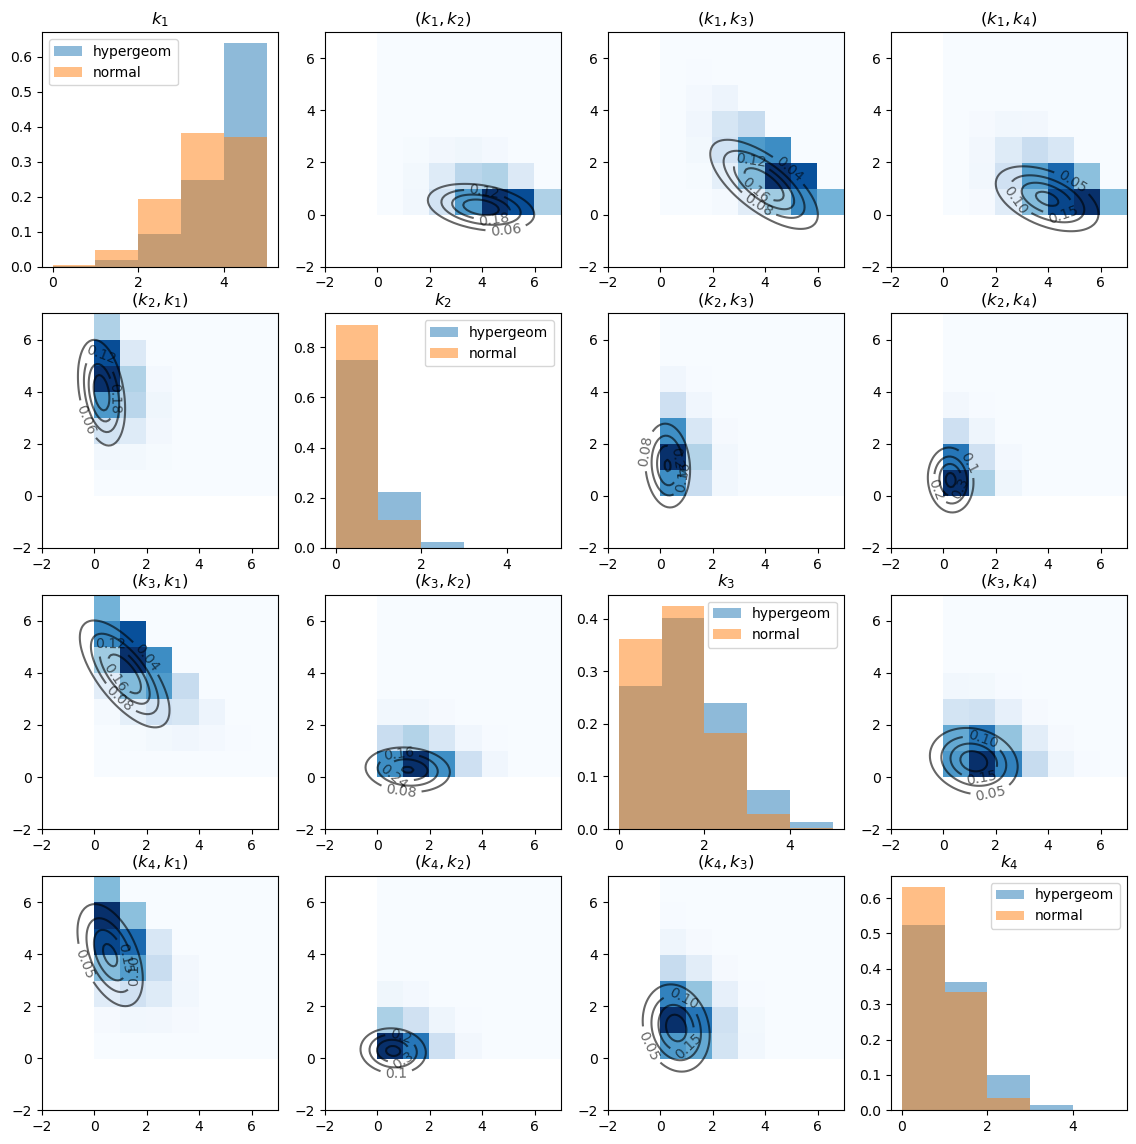

In [21]:
c = urn.c
fig, axs = plt.subplots(c, c, figsize=(14, 14))

# grids for ploting the bivariate Gaussian
x_grid = np.linspace(-2, n+1, 100)
y_grid = np.linspace(-2, n+1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

for i in range(c):
    axs[i, i].hist(sample[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='hypergeom')
    axs[i, i].hist(sample_normal[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='normal')
    axs[i, i].legend()
    axs[i, i].set_title('$k_{' +str(i+1) +'}$')
    for j in range(c):
        if i == j:
            continue

        # bivariate Gaussian density function
        Z = bivariate_normal(X, Y, μ, Σ, i, j)
        cs = axs[i, j].contour(X, Y, Z, 4, colors="black", alpha=0.6)
        axs[i, j].clabel(cs, inline=1, fontsize=10)

        # empirical multivariate hypergeometric distrbution
        count_mat = count(sample[:, i], sample[:, j], n)
        axs[i, j].pcolor(count_mat.T/size, cmap='Blues')
        axs[i, j].set_title('$(k_{' +str(i+1) +'}, k_{' + str(j+1) + '})$')

plt.show()

The diagonal graphs plot the marginal distributions of $k_i$ for
each $i$ using histograms.

Note the substantial differences between hypergeometric distribution and the approximating normal distribution.

The off-diagonal graphs plot the empirical joint distribution of
$k_i$ and $k_j$ for each pair $(i, j)$.

The darker the blue, the more data points are contained in the corresponding cell.  (Note that $k_i$ is on the x-axis and $k_j$ is on the y-axis).

The contour maps plot the bivariate Gaussian density function of $\left(k_i, k_j\right)$ with the population mean and covariance given by slices of $\mu$ and $\Sigma$ that we computed above.

Let's also test the normality for each $k_i$ using `scipy.stats.normaltest` that implements D’Agostino and Pearson's
test that combines skew and kurtosis to form an omnibus test of normality.

The null hypothesis is that the sample follows normal distribution.

> `normaltest` returns an array of p-values associated with tests for each $k_i$ sample.

In [22]:
test_multihyper = normaltest(sample)
test_multihyper.pvalue

array([0., 0., 0., 0.])

As we can see, all the p-values are almost $0$ and the null hypothesis is soundly rejected.

By contrast, the sample from normal distribution does not reject the null hypothesis.

In [23]:
test_normal = normaltest(sample_normal)
test_normal.pvalue

array([0.01370114, 0.00410949, 0.09831737, 0.91461599])

The lesson to take away from this is that the normal approximation is imperfect.